# Adaptive Kramers chains


In [1]:
import numpy as np
from dilutebrowniandynamics.simulate import simulate_batch
from dilutebrowniandynamics.molecules.adaptive_Kramers_chain import AdaptiveKramersChain

## Parameters definition

In [2]:
n_links = 1000       # Number of segments in the Kramers chain

n_ensemble = 160     # Number of molecules to simulate
n_rec = 2000        # Number of time steps to record
dt = .01           # Time step value (dimensionless)
n_proc = 16         # Number of processor cores to use

output_file = 'outputs/sandpit'

## Initialise molecules
Here we just draw random vectors from a normal distribution and rescale to unit vectors. To do this with call `from_normal_distribution` constructor. 

In [3]:
seq = np.random.SeedSequence(2022)
seeds = seq.spawn(n_ensemble)
# Starting vectors
molecules = [AdaptiveKramersChain.from_normal_distribution(n_links, seed)
             for seed in seeds]

## Initial relaxation
Thermalisation step.

In [4]:
gradU = np.zeros((3, 3))
observables, molecules_out = simulate_batch(molecules, gradU, n_rec, dt, n_proc)

Physical time to compute: 20.0
Calculation started on 16 cores.


100%|██████████| 160/160 [02:57<00:00,  1.11s/it]


We can investigate the chains distribution.

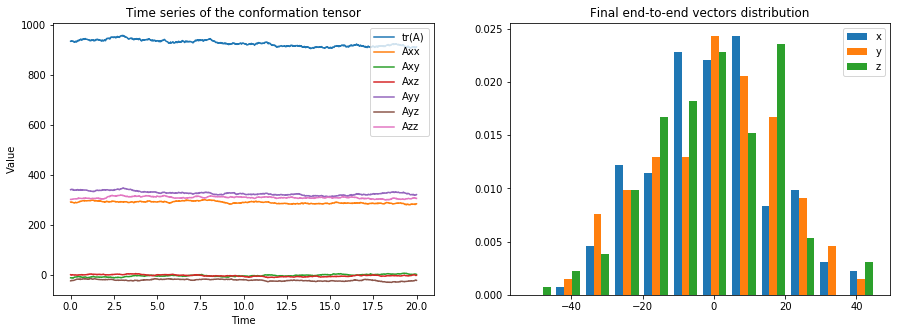

In [5]:
t = np.arange(n_rec)*dt
A = observables['A_average']
trA = np.trace(A, axis1=1, axis2=2)
REEs = np.array([molecule.REE for molecule in molecules_out])

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(t, trA, label='tr(A)')
ax[0].plot(t, A[:,0,0], label='Axx')
ax[0].plot(t, A[:,0,1], label='Axy')
ax[0].plot(t, A[:,0,2], label='Axz')
ax[0].plot(t, A[:,1,1], label='Ayy')
ax[0].plot(t, A[:,1,2], label='Ayz')
ax[0].plot(t, A[:,2,2], label='Azz')
ax[0].legend()
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Value')
ax[0].set_title('Time series of the conformation tensor')
bins = int(np.sqrt(n_ensemble))
ax[1].hist([REEs[:,0], REEs[:,1], REEs[:,2]], bins=bins, density=True, label=['x','y','z'])
ax[1].legend()
ax[1].set_title('Final end-to-end vectors distribution')
plt.show()

## Simulation
Now let's simulate a sudden uniaxial elongation followed by relaxation. We first define a callable `gradU` function for this scenario.

In [6]:
from scipy.interpolate import interp1d
t_base = [0, # Elongation starts at t = 0
          10] # Relaxation will start from t = 1
gradU_base = [np.diag([1, -.5, -.5]),
              np.zeros((3, 3))]
gradU = interp1d(t_base, gradU_base, axis=0, kind='previous', bounds_error=False, 
                 fill_value=(gradU_base[0], gradU_base[-1]), assume_sorted=True)

In [7]:
n_rec = 1_000
observables, molecules_out = simulate_batch(molecules_out, gradU, n_rec, dt, n_proc)

Physical time to compute: 10.0
Calculation started on 16 cores.


  2%|▎         | 4/160 [01:12<46:52, 18.03s/it]  Process ForkPoolWorker-32:
Process ForkPoolWorker-31:
Process ForkPoolWorker-30:
Process ForkPoolWorker-26:
Process ForkPoolWorker-24:
Process ForkPoolWorker-27:
Process ForkPoolWorker-25:
Process ForkPoolWorker-28:
Process ForkPoolWorker-18:
Process ForkPoolWorker-29:
Process ForkPoolWorker-23:
Process ForkPoolWorker-20:
Process ForkPoolWorker-21:
Process ForkPoolWorker-19:
Process ForkPoolWorker-22:
Process ForkPoolWorker-17:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/etienne/miniconda3/lib/python3.7/multiprocessing/p

KeyboardInterrupt: 

In [ ]:
t = np.arange(n_rec)*dt
A = observables['A_average']
trA = np.trace(A, axis1=1, axis2=2)
REEs = np.array([molecule.REE for molecule in molecules_out])

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(t, trA, label='tr(A)')
ax[0].plot(t, A[:,0,0], label='Axx')
ax[0].plot(t, A[:,0,1], label='Axy')
ax[0].plot(t, A[:,0,2], label='Axz')
ax[0].plot(t, A[:,1,1], label='Ayy')
ax[0].plot(t, A[:,1,2], label='Ayz')
ax[0].plot(t, A[:,2,2], label='Azz')
ax[0].legend()
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Value')
ax[0].set_title('Time series of the conformation tensor')
bins = int(np.sqrt(n_ensemble))
ax[1].hist([REEs[:,0], REEs[:,1], REEs[:,2]], bins=bins, density=True, label=['x','y','z'])
ax[1].legend()
ax[1].set_title('Final end-to-end vectors distribution')
plt.show()

We can see that the average square length, tr(A), is constraint by (n_links)².

## Stress
We now examine the stress tensor.

In [ ]:
S = observables['S_average']
trS = np.trace(S, axis1=1, axis2=2)

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].semilogy(t, trS, label='tr(S)')
ax[0].semilogy(t, S[:,0,0], label='Sxx)')
ax[0].set_title('Log Trace Stress')
ax[0].set_xlabel('Time')
ax[0].legend()
ax[1].plot(t, S[:,0,0], label='Sxx')
ax[1].plot(t, S[:,0,1], label='Sxy')
ax[1].plot(t, S[:,1,1], label='Syy')
ax[1].legend()
ax[1].set_xlabel('Time')
ax[1].set_title('Stress tensor')
plt.show()

A few remarks:
1. The stress is composed of a viscous part and visco-elastic part. When the flow is turned off, the viscous part vanishes instantaneously, while the viscoelastic part is relaxed over time.
2. The noise is very important with this estimator due to the rigid constaint.